In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import cv2

from cifar import CifarDataset

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset = CifarDataset('./data/cifar-10-batches-py', device)
test_dataset, val_dataset = torch.utils.data.random_split(TensorDataset(dataset.test_x, dataset.test_y), [5000, 5000])
print("training samples: %d" % len(dataset))
print("validation samples: %d" % len(val_dataset))
print("test samples: %d" % len(test_dataset))

training samples: 50000
validation samples: 5000
test samples: 5000


In [3]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.Dropout2d(0.25),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.Dropout2d(0.25),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.Dropout2d(0.25),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(512*2*2, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
).to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True,
    factor=0.2, patience=5, threshold=1e-3, threshold_mode='rel', min_lr=5e-6)

In [12]:
from torchsummary import summary
summary(model, torch.zeros(1, 3, 32, 32))

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: [Conv2d: 1-1, BatchNorm2d: 1-2, ReLU: 1-3, MaxPool2d: 1-4, Conv2d: 1-5, Dropout2d: 1-6, BatchNorm2d: 1-7, ReLU: 1-8, MaxPool2d: 1-9, Conv2d: 1-10, Dropout2d: 1-11]

In [ ]:
def train_batch(x, y, model, lossfn, opt):
    model.train()
    yp = model(x)
    loss = lossfn(yp, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

@torch.no_grad()
def val_loss(x, y, model, lossfn):
    model.eval()
    yp = model(x)
    loss = lossfn(yp, y)
    return loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    yp = model(x).argmax(dim=1)
    is_correct = (y == yp).cpu().numpy().tolist()
    return is_correct

In [ ]:
import time
train_losses = []
val_losses = []
val_acces = []

for epoch in range(50):
    start = time.time()

    # training
    epoch_train_losses = []
    for x, y in train_loader:
        loss = train_batch(x, y, model, lossfn, optimizer)
        epoch_train_losses.append(loss)
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    epoch_val_losses = []
    epoch_val_acces = []
    for x, y in val_loader:
        loss = val_loss(x, y, model, lossfn)
        epoch_val_losses.append(loss)
        is_correct = accuracy(x, y, model)
        epoch_val_acces.extend(is_correct)
    epoch_val_loss = np.mean(epoch_val_losses)
    val_losses.append(epoch_val_loss)
    epoch_val_acc = np.mean(epoch_val_acces)
    val_acces.append(epoch_val_acc)
    scheduler.step(epoch_val_loss)

    end = time.time()
    print("epoch %d, %.2fs, trloss: %.2f, valloss: %.2f, valcc: %.2f" %
          (epoch, end-start, epoch_train_loss, epoch_val_loss, epoch_val_acc*100))

test_acces = []
for x, y in test_loader:
    is_correct = accuracy(x, y, model)
    test_acces.extend(is_correct)
test_acc = np.mean(test_acces)
print("======================")
print("final test acc %.2f" % (test_acc*100))
print("======================")


epoch 0, 11.37s, trloss: 1.33, valloss: 1.05, valcc: 63.42
epoch 1, 11.26s, trloss: 0.97, valloss: 0.92, valcc: 68.12
epoch 2, 11.30s, trloss: 0.82, valloss: 0.82, valcc: 71.52
epoch 3, 11.27s, trloss: 0.74, valloss: 0.80, valcc: 72.42
epoch 4, 11.52s, trloss: 0.68, valloss: 0.68, valcc: 76.82
epoch 5, 11.49s, trloss: 0.63, valloss: 0.72, valcc: 75.12
epoch 6, 11.20s, trloss: 0.58, valloss: 0.74, valcc: 76.36
epoch 7, 11.21s, trloss: 0.55, valloss: 0.72, valcc: 76.20
epoch 8, 11.17s, trloss: 0.51, valloss: 0.69, valcc: 77.64
epoch 9, 11.22s, trloss: 0.48, valloss: 0.67, valcc: 78.42
epoch 10, 11.17s, trloss: 0.45, valloss: 0.82, valcc: 75.38
epoch 11, 11.27s, trloss: 0.43, valloss: 0.71, valcc: 77.54
epoch 12, 11.18s, trloss: 0.41, valloss: 0.65, valcc: 79.94
epoch 13, 11.19s, trloss: 0.39, valloss: 0.69, valcc: 77.80
epoch 14, 11.19s, trloss: 0.37, valloss: 0.68, valcc: 78.56
epoch 15, 11.18s, trloss: 0.35, valloss: 0.83, valcc: 76.84
epoch 16, 11.18s, trloss: 0.34, valloss: 0.66, val

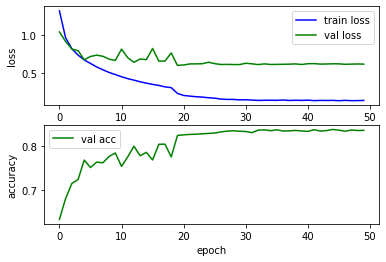

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(train_losses, 'b', label='train loss')
plt.plot(val_losses, 'g', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_acces, 'g', label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()